## Multilabel classification with Logic Tensor Networks

This is a basic example in which we learn to ground unary predicates $A,B$ that are defined in the space of $[0,1]^2$.
We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$. $B$ is defined as the 

The basic theory/knowledgebase/model is
* we train $A$ on positive data
* we train $B$ on positive data
* we define $B$ as the opposite of $A$ using a set of axioms

Notice that in this version, we only have positive training data for $A$ and $B$. The rest follows from background knowledge (axioms), given to the system apriori

In [1]:
import logging;logging.basicConfig(level=logging.INFO);
import numpy as np;
import matplotlib.pyplot as plt; 
import logictensornetworks_wrapper as ltnw;

Set the number of random training samples, the maximum number of epochs and how often we query the knowledgebase sat level in training.

In [2]:
nr_samples=500
max_epochs=30000
track_sat_levels=5000
sat_level_epsilon=.99

Sample random data from $[0,1]^2$

In [3]:
data=np.random.uniform([0,0],[1.,1.],(nr_samples,2)).astype(np.float32)

Our groundtruth positive training data for A is close to the center (.5,.5). All other data is considered as positive example of $B$.

In [4]:
data_A=data[np.where(np.sum(np.square(data-[.5,.5]),axis=1)<.09)]
data_B=data[np.where(np.sum(np.square(data-[.5,.5]),axis=1)>=.09)]

We use three variables for feeding data to $A,B$. All points ($\mathrm{?data}$), points for which A is true ($\mathrm{?data\_A}$), points for which $B$ is true ($\mathrm{?data\_B}$).

In [5]:
ltnw.variable("?data",data);
ltnw.variable("?data_A",data_A);
ltnw.variable("?data_B",data_B);

Define the predicates $A,B$ with arity 1 (single argument) and 2 dimensional input (since the domain is $[0,1]^2$)

In [6]:
ltnw.predicate("A",2);
ltnw.predicate("B",2);

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{?data\_A}$, $A$ should be true. For all points in $\mathrm{?data\_B}$, $B$ is true. For all points, iff  $A$ is true, $B$ is not true and vice versa.

In [7]:
ltnw.axiom("forall ?data_A: A(?data_A)")
ltnw.axiom("forall ?data_B: B(?data_B)")

ltnw.axiom("forall ?data: A(?data) -> ~B(?data)")
ltnw.axiom("forall ?data: ~A(?data) -> B(?data)")
ltnw.axiom("forall ?data: ~B(?data) -> A(?data)")
ltnw.axiom("forall ?data: B(?data) -> ~A(?data)")

print("\n".join(sorted(ltnw.AXIOMS.keys())))

forall ?data: A(?data) -> ~B(?data)
forall ?data: B(?data) -> ~A(?data)
forall ?data: ~A(?data) -> B(?data)
forall ?data: ~B(?data) -> A(?data)
forall ?data_A: A(?data_A)
forall ?data_B: B(?data_B)


Initialize the knowledgebase and train the knowledgebase.

In [8]:
ltnw.initialize_knowledgebase(initial_sat_level_threshold=.1)
sat_level=ltnw.train(track_sat_levels=track_sat_levels,sat_level_epsilon=sat_level_epsilon,max_epochs=max_epochs)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.7797398
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.7797398
INFO:logictensornetworks_wrapper:TRAINING 5000 sat level -----> 0.8354028
INFO:logictensornetworks_wrapper:TRAINING 10000 sat level -----> 0.8459644
INFO:logictensornetworks_wrapper:TRAINING 15000 sat level -----> 0.87417203
INFO:logictensornetworks_wrapper:TRAINING 20000 sat level -----> 0.912983
INFO:logictensornetworks_wrapper:TRAINING 25000 sat level -----> 0.9397878
INFO:logictensornetworks_wrapper:TRAINING finished after 29999 epochs with sat level 0.95412713


We can now query the knowledgebase for various points in the domain.

In [9]:
ltnw.constant("a",[0.5,.5])
ltnw.constant("b",[1.,1.])
print("a is in A: %s" % ltnw.ask("A(a)"))
print("b is in A: %s" % ltnw.ask("A(b)"))
print("a is in B: %s" % ltnw.ask("B(a)"))
print("b is in B: %s" % ltnw.ask("B(b)"))

a is in A: [0.99063045]
b is in A: [0.00041319]
a is in B: [0.0130351]
b is in B: [0.99967825]


Visualize results

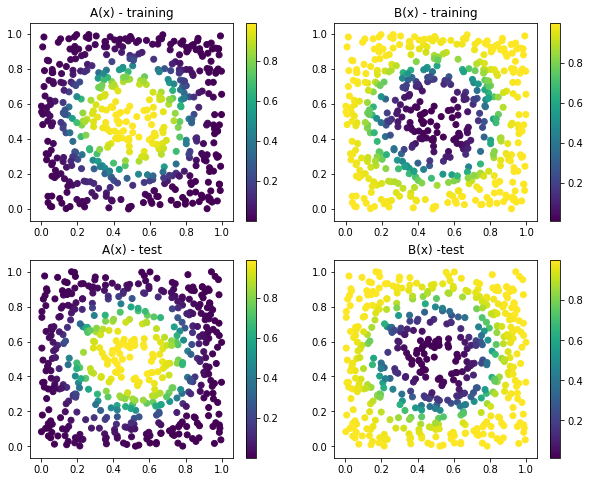

In [10]:
result=ltnw.ask("A(?data)")
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title("A(x) - training")
plt.scatter(data[:,0],data[:,1],c=result.squeeze())
plt.colorbar()

plt.subplot(2,2,2)
result=ltnw.ask("B(?data)")
plt.title("B(x) - training")
plt.scatter(data[:,0],data[:,1],c=result.squeeze())
plt.colorbar()

data_test=np.random.uniform([0,0],[1.,1.],(nr_samples,2)).astype(np.float32)
ltnw.variable("?data_test",data_test)
result=ltnw.ask("A(?data_test)")
plt.subplot(2,2,3)
plt.title("A(x) - test")
plt.scatter(data_test[:,0],data_test[:,1],c=result.squeeze())
plt.colorbar()

result=ltnw.ask("B(?data_test)")
plt.subplot(2,2,4)
plt.title("B(x) -test")
plt.scatter(data_test[:,0],data_test[:,1],c=result.squeeze())
plt.colorbar()

plt.show()